In [1]:
import os,cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
GPU = tf.config.list_logical_devices('GPU')[0].name
sns.set_theme()

2022-07-31 23:27:00.939347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 23:27:00.993358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 23:27:00.993700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 23:27:00.994704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
from lib.extract import trainDF, testDF;

imScanTest: 100%|█████████████████████████████| 196/196 [00:06<00:00, 31.07it/s]


In [3]:
# compute Intersection-over-Union metrics
def IOU(y_true,y_pred):
    """arguments:
    ----------
    y_true : true bounding box coordinates as list
    y_pred : predicted bounding box coordinates as list
    expected shape of arguments: (None,4)
    
    returns: bounding box metric, Intersection-over-Union as list of shape (None,)
    """
    
    import numpy as np
    from tensorflow.keras import backend as K
    
    # intersection coordinates (x1,y1)
    x1 = np.maximum(y_true[:,0],y_pred[:,0])
    y1 = np.maximum(y_true[:,1],y_pred[:,1])
    # intersection coordinates (x2,y2)
    x2 = np.minimum(y_true[:,2],y_pred[:,2])
    y2 = np.minimum(y_true[:,3],y_pred[:,3])    
    # compute areas
    inter_area = (x2 - x1) * (y2 - y1)
    union_area = (y_true[:,2] - y_true[:,0]) * (y_true[:,3] - y_true[:,1]) * 1.0 # true bBox
    union_area += (y_pred[:,2] - y_pred[:,0]) * (y_pred[:,3] - y_pred[:,1]) # predicted bBox
    union_area -= inter_area # intersection area
    return (inter_area / (union_area + K.epsilon()))

def IoU(y_true, y_pred):
    """wraps the IOU function into TensorFlow op for eager execution"""
    return tf.py_function(IOU,[y_true, y_pred],tf.float32)

### RCNN based object detection<br>
the Region-proposal based Convolutional Neural Networks is a State-of-the-Art technique designed to solve object detection use cases.
Mostly the applications include multi-instance localisation or Foreground-Background segregation. 

the principle of operation is as follows:
* proposals of ROI in the given image space
* pass each ROI through a CNN model for class prediction
* summarise the predictions of selected ROIs and append respective bounding boxes to the original image

as each image is now split into multiple ROI, the quantum of data explodes, causing...
* better chances for the network to learn
* at the cost of hightened computational requirements & costs

also, since this 2-stage SOTA techinque leverages openCV's Selective Search Algorithm, which is currently not designed to latch on to GPUs, the overall computational times are increased multi-folds

Considering the resource hungry model, and the given computational capacity avialble, we will restrict the model training to just 50 images.

In [4]:
# select a reduced subset of training & teting images
selTrain=trainDF.sample(50,replace=False,random_state=100,ignore_index=True)
selTest=testDF.sample(50,replace=False,random_state=100,ignore_index=True)

In [5]:
# move data to array
selTrainImagePath = selTrain.ImagePath.values.copy()
selTrainBBox = selTrain[["x1","y1","x2","y2"]].values.copy()
selTestImagePath = selTest.ImagePath.values.copy()
selTestBBox = selTest[["x1","y1","x2","y2"]].values.copy()

In [6]:
# instantiate SelectiveSearchAlgorithm
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [12]:
def ROIextract(imPath,bBox):
    """read the image and propose ROIs
    update training/testing dataset
    """
    # read image
    rawImage = np.array(Image.open(imPath))
    # assert image dimensions
    if len(rawImage.shape)!=3 or rawImage.shape[-1]!=3:
        return [],[]
    # associate selective search to the image
    ss.setBaseImage(rawImage) 
    # fast search option
    ss.switchToSelectiveSearchFast() 
    # generate proposals
    roiProposal = ss.process() 
    # the proposals are of the format [x,y,w,h]
    # change them to [x1,y1,x2,y2] by using [x,y,x+w,y+h]
    roiProposal[:,2] = np.add(roiProposal[:,2],roiProposal[:,0])
    roiProposal[:,3] = np.add(roiProposal[:,3],roiProposal[:,1])
    # image size stacked to match ROI proposals
    imSize = np.repeat(np.append(rawImage.shape[:2],
                                 rawImage.shape[:2],axis=0).reshape(1,-1),
                       roiProposal.shape[0],axis=0)
    # bound ROI proposals to image dimensions
    roiProposal = np.minimum(roiProposal,imSize)
    roiProposal = np.maximum(roiProposal,np.zeros_like(roiProposal))
    # count of proposals
    roiQty = roiProposal.shape[0] 
    # array of true bounding box coordinates repeated to match proposals shape
    trueBBox = np.repeat(bBox.reshape(1,-1),roiQty,axis=0) 
    # compute IOU for all the proposals
    ious = IOU(trueBBox,roiProposal)
    # first 30 proposals with IOU >= 0.7 & IOU <= 1.0 for positive samples
    foreGroundCoord = roiProposal[np.argwhere((ious<=1.0) & (ious>=0.7)).reshape(1,-1)[0][:30]]
    # first 30 proposals with IOC <= 0.3 & IOU >= 0.0 for negative samples
    backGroundCoord = roiProposal[np.argwhere((ious>0.0) & (ious<=0.3)).reshape(1,-1)[0][:30]]    
    # crop images defined by the roi coordinates
    fgROI = np.array(list(map(lambda x: cv2.resize(rawImage[x[0]:x[2],x[1]:x[3]],(224,224)),foreGroundCoord)))
    bgROI = np.array(list(map(lambda x: cv2.resize(rawImage[x[0]:x[2],x[1]:x[3]],(224,224)),backGroundCoord)))
    # add the ROIs and corresponding labels to the dataset
    tmpROI = []
    tmpROI.extend(fgROI)
    tmpROI.extend(bgROI)
    tmpLabel=[]
    tmpLabel.extend(np.ones(fgROI.shape[0],dtype=int))
    tmpLabel.extend(np.zeros(bgROI.shape[0],dtype=int))
    
    return tmpROI,tmpLabel

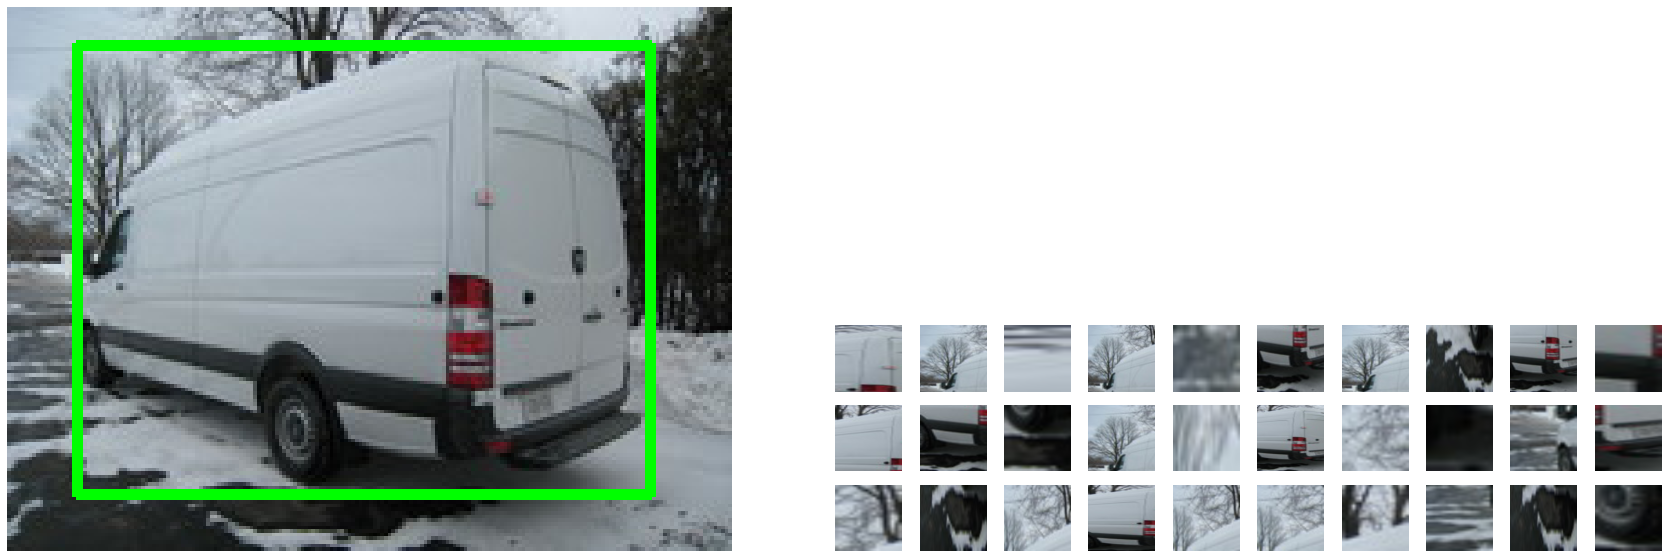

In [8]:
index = np.random.randint(0,50)
# lets visualise a sample of ROI extraction
rois,labels = ROIextract(selTrainImagePath[index],selTrainBBox[index])
rois = np.array(rois)
labels = np.array(labels)

plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
img = np.array(Image.open(selTrainImagePath[index]))
box = selTrainBBox[index]
cv2.rectangle(img,box[:2],box[2:],(0,255,0),2)
plt.imshow(Image.fromarray(img))
plt.grid(None)
plt.axis('off');

r = 0
c = 11
i = (r*20)+c
for roi in rois[np.argwhere(labels==1).reshape(1,-1)[0]][:30]:
    plt.subplot(7,20,i)
    plt.imshow(Image.fromarray(roi))
    plt.grid(None)
    plt.axis('off');
    if c<20:
        c+=1
    else:
        r+=1
        c=11
    i = (r*20)+c   
    
r = 4
c = 11
i = (r*20)+c
for roi in rois[np.argwhere(labels==0).reshape(1,-1)[0]][:30]:
    plt.subplot(7,20,i)
    plt.imshow(Image.fromarray(roi))
    plt.grid(None)
    plt.axis('off');
    if c<20:
        c+=1
    else:
        r+=1
        c=11
    i = (r*20)+c 

In [9]:
%%time
rTrainROIs = []
rTrainLabels = []

# extract ROIs and labels for training images
for (imPath,bBox) in tqdm(zip(selTrainImagePath,selTrainBBox),desc="ROIextraction"):
    rois,labels = ROIextract(imPath,bBox)
    rTrainROIs.extend(rois)
    rTrainLabels.extend(labels)

ROIextraction: 50it [05:13,  6.28s/it]

CPU times: user 7min 11s, sys: 19.9 s, total: 7min 31s
Wall time: 5min 13s


In [13]:
%%time
rTestROIs = []
rTestLabels = []

# extract ROIs and labels for testing images
for (imPath,bBox) in tqdm(zip(selTestImagePath,selTestBBox),desc="ROIextraction"):
    rois,labels = ROIextract(imPath,bBox)
    rTestROIs.extend(rois)
    rTestLabels.extend(labels)

ROIextraction: 50it [04:22,  5.24s/it]

CPU times: user 6min 31s, sys: 13.5 s, total: 6min 45s
Wall time: 4min 22s


In [15]:
rTrainROIs = np.array(rTrainROIs)
rTrainLabels = np.array(rTrainLabels)
rTestROIs = np.array(rTestROIs)
rTestLabels = np.array(rTestLabels)

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalMaxPool2D,Dense,BatchNormalization,Dropout

# load application
tNet = VGG16(input_shape=(224,224,3),include_top=False, weights='imagenet')
# flatten with pooling
pool = GlobalMaxPool2D(name="CustomLayerStart")(tNet.output)
# classifier branch object detection
D1 = Dense(1024,activation='relu')(pool)
B1 = BatchNormalization()(D1)
DO1 = Dropout(0.5)(B1)
D2 = Dense(256,activation='relu')(DO1)
B2 = BatchNormalization()(D2)
DO2 = Dropout(0.5)(B2)
classifier = Dense(1,activation='sigmoid',name="labels")(DO2)

# assemble the network
model = Model(inputs=tNet.inputs,outputs=classifier,name="R-CNN")

# freeze application layers and open classifer & regressor for training
for layer in model.layers[:-8]:
    layer.trainable = False
    
model.compile(optimizer=Adam(lr=0.0001),
              loss=tf.keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [20]:
logs = model.fit(x=rTrainROIs,y=rTrainLabels,epochs=5,batch_size=64,validation_split=0.1)

Epoch 1/5


2022-07-31 23:44:36.435454: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 224738304 exceeds 10% of free system memory.
2022-07-31 23:44:36.605523: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 224738304 exceeds 10% of free system memory.
2022-07-31 23:44:38.024834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-31 23:44:38.374265: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-31 23:44:38.493849: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-31 23:44:38.601510: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.82GiB with freed_b

23/24 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5700

2022-07-31 23:45:07.945011: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


24/24 [==============================] - 43s 1s/step - loss: 0.0000e+00 - accuracy: 0.5687 - val_loss: 0.0000e+00 - val_accuracy: 0.4398
Epoch 2/5
24/24 [==============================] - 22s 926ms/step - loss: 0.0000e+00 - accuracy: 0.7180 - val_loss: 0.0000e+00 - val_accuracy: 0.4819
Epoch 3/5
24/24 [==============================] - 23s 952ms/step - loss: 0.0000e+00 - accuracy: 0.7307 - val_loss: 0.0000e+00 - val_accuracy: 0.5120
Epoch 4/5
24/24 [==============================] - 23s 962ms/step - loss: 0.0000e+00 - accuracy: 0.7528 - val_loss: 0.0000e+00 - val_accuracy: 0.5723
Epoch 5/5
24/24 [==============================] - 23s 967ms/step - loss: 0.0000e+00 - accuracy: 0.7636 - val_loss: 0.0000e+00 - val_accuracy: 0.6145


In [22]:
model.evaluate(x=rTrainROIs,y=rTrainLabels)

2022-07-31 23:49:32.460374: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 249725952 exceeds 10% of free system memory.


52/52 [==============================] - 29s 485ms/step - loss: 0.0000e+00 - accuracy: 0.6534


[0.0, 0.6534056663513184]

it could be found that the R-CNN converges pretty quick,
but the resource & time consumed for just 5o images doesnot justify its application to 16000 images.
Hence we shall attempt an improvisation of the localisation + classification